In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as ps

pd.set_option('display.max_rows', 4, 'display.max_columns', None)

In [2]:
results_his = pd.read_csv('results_counts_his.csv')
results_his['where'] = 'his'
results_tf = pd.read_csv('results_counts_tf.csv')
results_tf['where'] = 'tf'

results = pd.concat([results_his, results_tf], ignore_index=True)
# results = results[results['metric']=='pr_auc']
results = results[results['transition'].isin(['hg38->mm10', 'mm10->hg38'])]

results['where'] = results['where'].str.replace('his', 'HM').str.replace('tf', 'TF')
results['metric'] = results['metric'].str.replace('accuracy', 'ACC').str.replace('pr_auc', 'PR AUC').str.replace('roc_auc', 'ROC')
results['method'] = results['method'].str.upper()
results['variable'] = results['variable'].str.replace('better_count', 'Better').str.replace('worse_count', 'Worse')

results['value_abs'] = results['value'].abs()

results = pd.concat([
    results,
    results.groupby(['method', 'transition', 'metric', 'variable'])[['value', 'value_abs']].sum().reset_index().assign(where='All'),
])


results['where_total'] = results.groupby(['method', 'transition', 'metric', 'where'])['value_abs'].transform('sum')
results['value_abs_rel'] = results['value_abs'] / results['where_total']
results['value_text'] = results['value_abs'].astype(str) + '/' + results['where_total'].astype(str)

results['transition'] = results['transition'].str.replace('->', ' ➙ ')

results = results[results['variable'] == 'Better']

results

,method,transition,metric,variable,value,where,value_abs,where_total,value_abs_rel,value_text
3,ADDA,hg38 ➙ mm10,ACC,Better,5,HM,5,59,0.084746,5/59
4,ADDA,hg38 ➙ mm10,PR AUC,Better,2,HM,2,59,0.033898,2/59
...,...,...,...,...,...,...,...,...,...,...
104,MDD,mm10 ➙ hg38,PR AUC,Better,2,All,2,71,0.028169,2/71
106,MDD,mm10 ➙ hg38,ROC,Better,3,All,3,71,0.042254,3/71


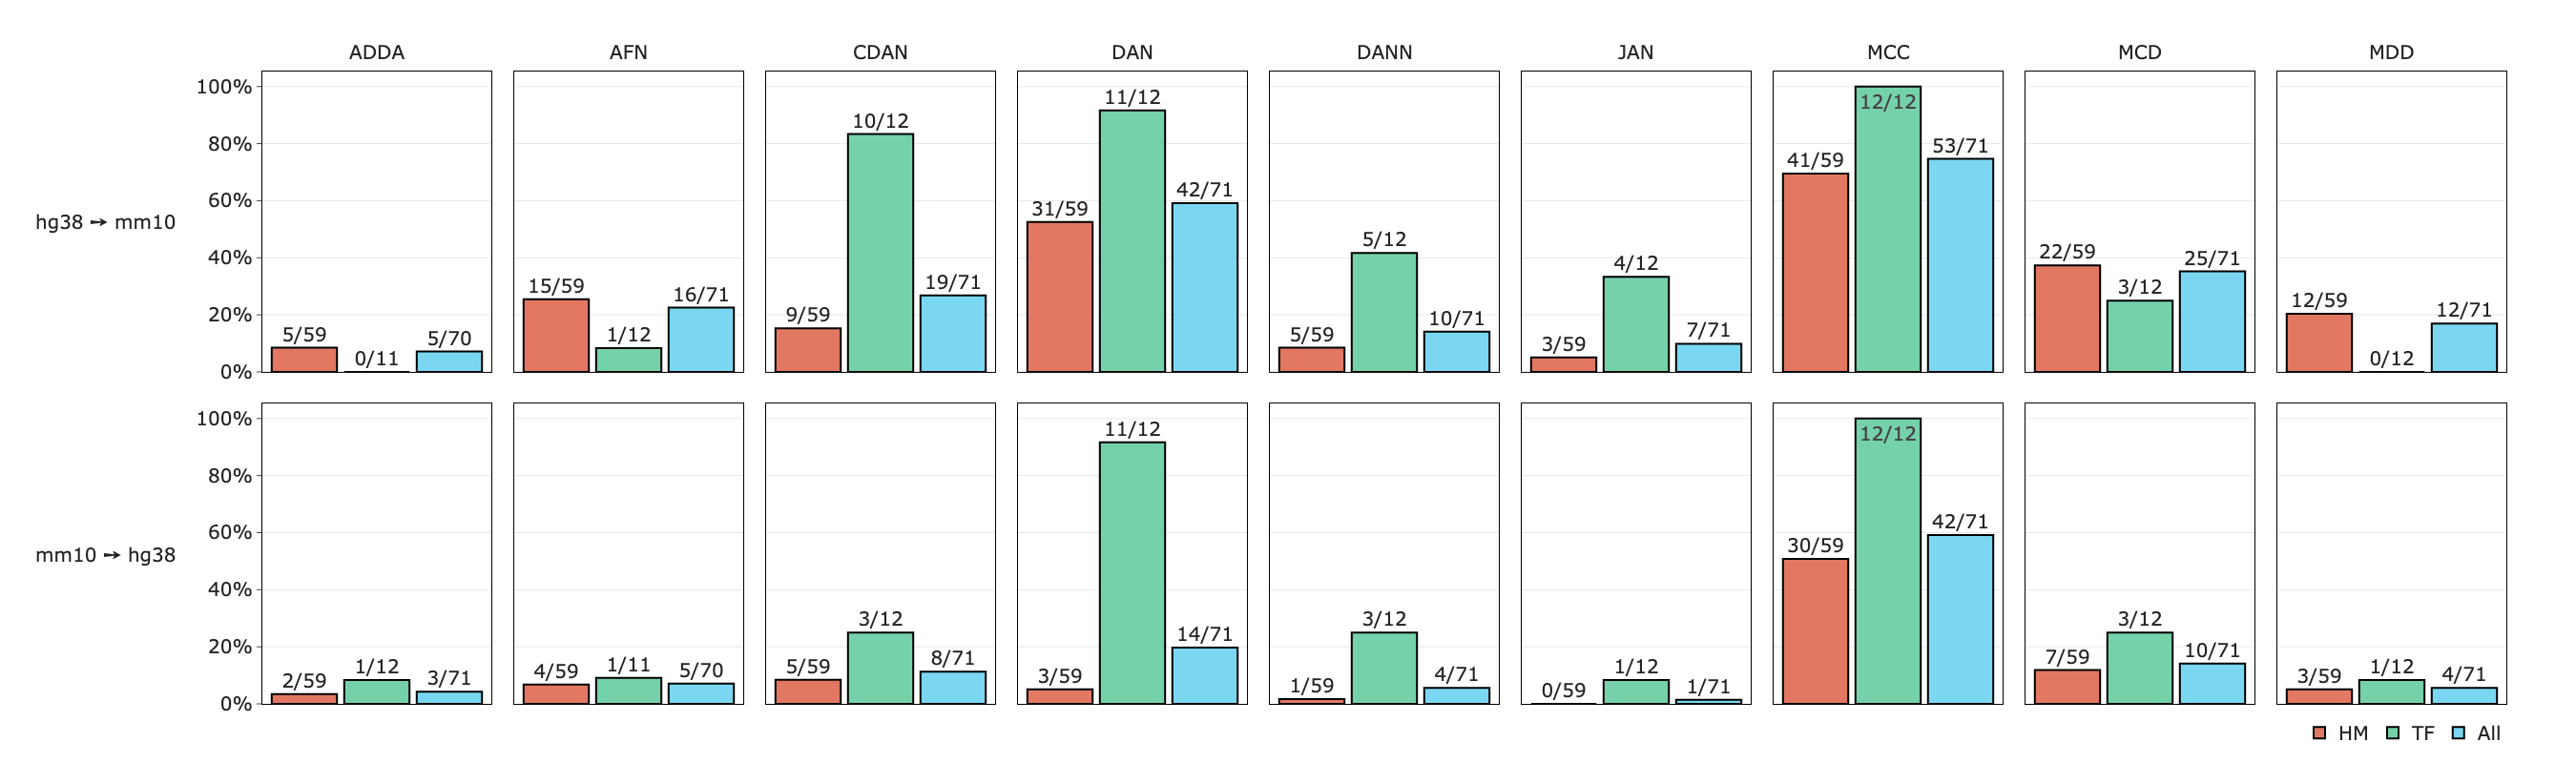

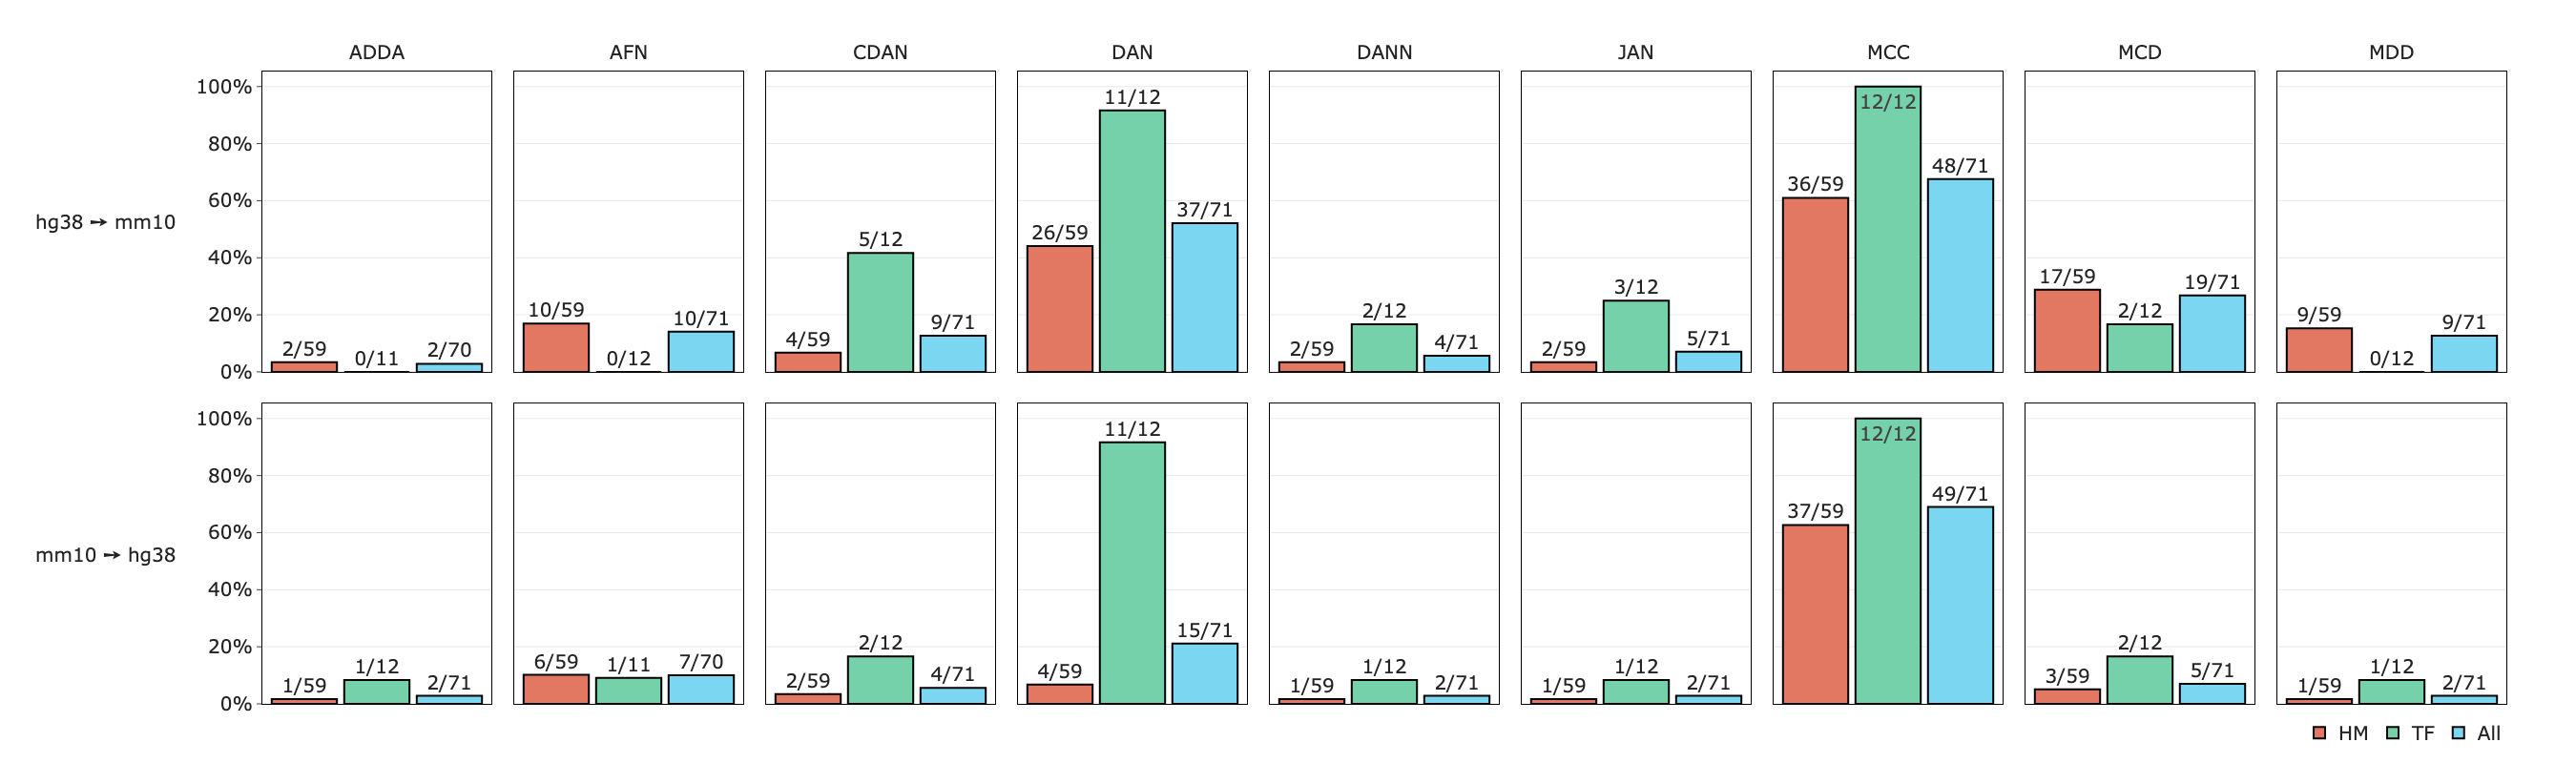

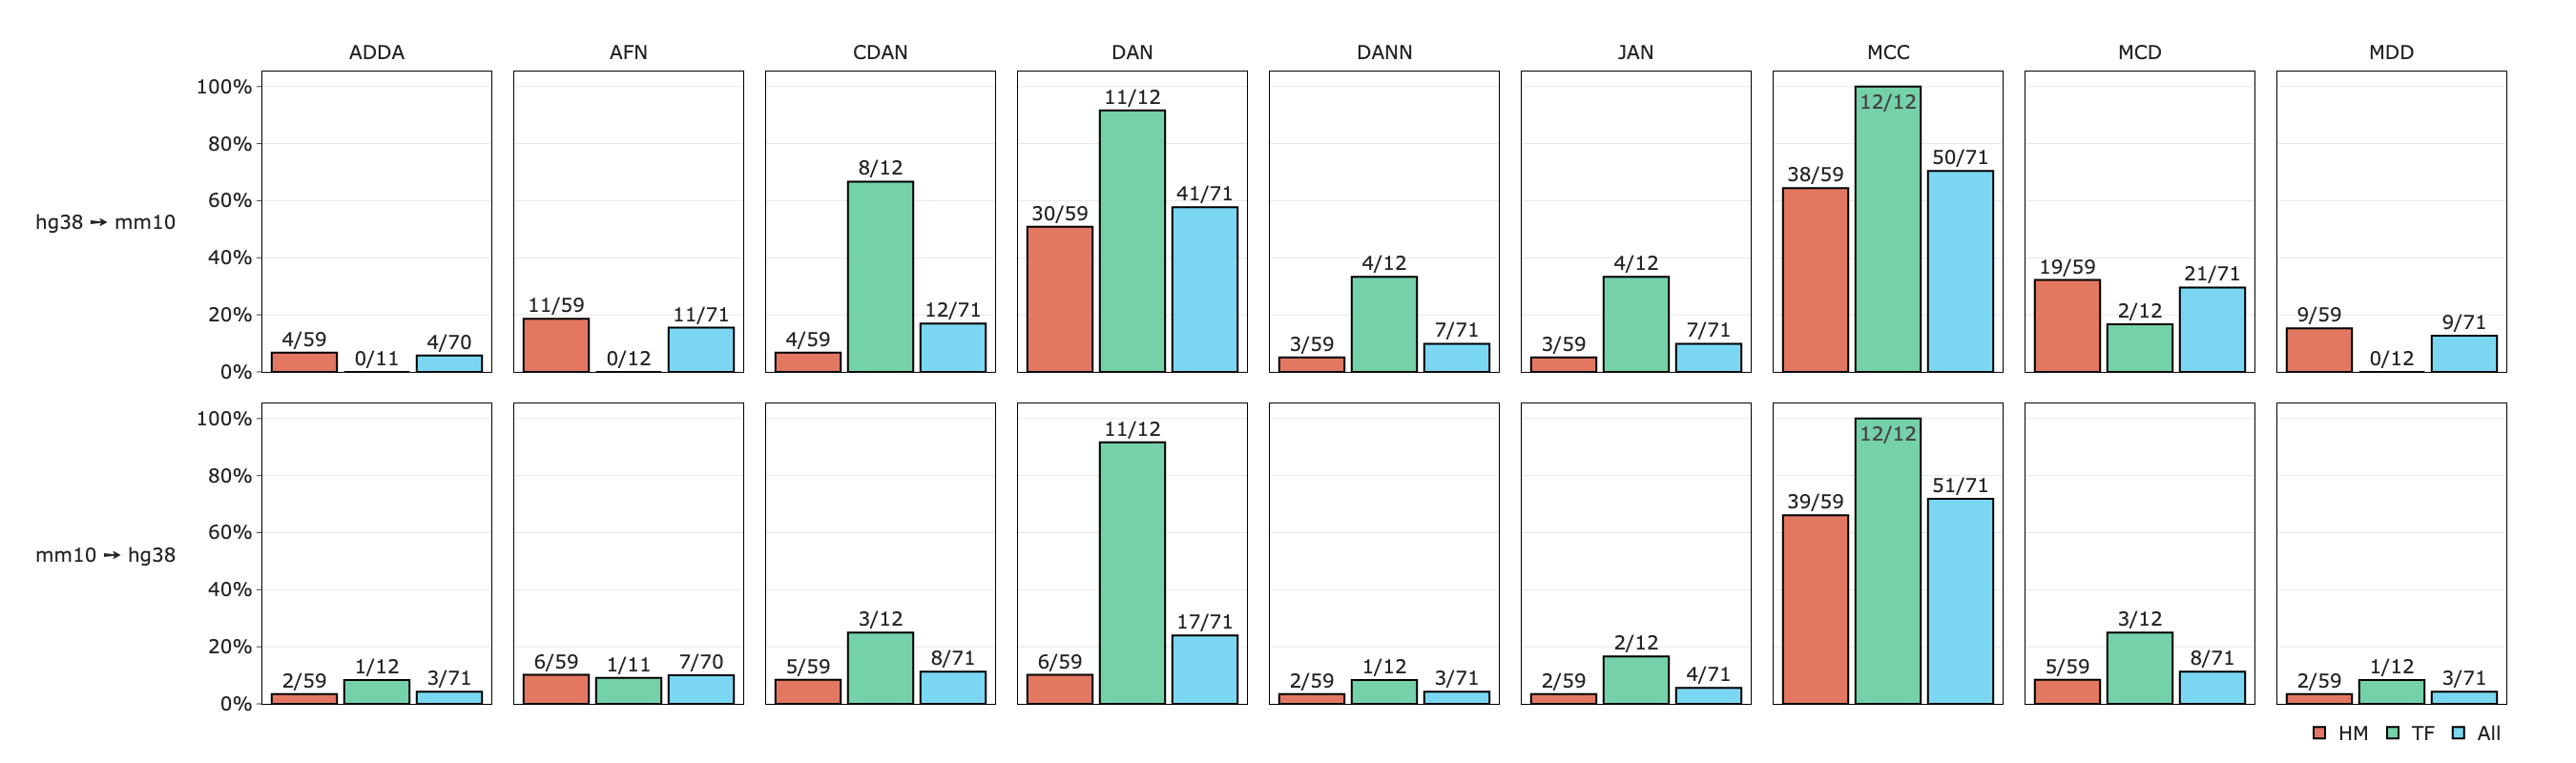

In [3]:
unique_methods = sorted(results['method'].unique())
unique_metrics = sorted(results['metric'].unique())
unique_transitions = sorted(results['transition'].unique())
unique_where = sorted(results['where'].unique())

colors = {
    'HM': "#E27862",
    'TF': "#75D1A9",
    'All': "#7BD7F1",
}


for metric in ["ACC", "PR AUC", "ROC"]:
    n_rows = len(unique_transitions)
    n_cols = len(unique_methods)
    fig = ps.make_subplots(
        rows=n_rows,
        cols=n_cols,
        shared_yaxes="all",
        horizontal_spacing=0.01,
        vertical_spacing=0.05,
        column_titles=unique_methods,
        row_titles=unique_transitions,
        # x_title="Flipon count",
    )

    for i, unique_transition in enumerate(unique_transitions):
        for j, unique_method in enumerate(unique_methods):
            df = (
                results[
                    (results["transition"] == unique_transition)
                    & (results["method"] == unique_method)
                    & (results["metric"] == metric)
                ]
            )

            for idx, row in df.iterrows():
                sub = go.Bar(
                    x=[row["method"]],
                    y=[row["value_abs_rel"]],
                    name=row["where"],
                    text=row['value_text'],
                    textposition="outside" if row["value_abs_rel"]<.95 else "inside",
                    # texttemplate="%{x:,d}",
                    marker=dict(color=colors[row["where"]],line=dict(width=2, color='black')),
                    # width=0.24,
                    # orientation="h",
                    showlegend=True if (i == 0 and j == 0) else False,
                )
                fig.add_trace(sub, row=i + 1, col=j + 1)
            fig.update_xaxes(ticks="", row=i + 1, col=j + 1)


    fig.update_xaxes(
        showticklabels=False, showline=True, linewidth=1, linecolor="black", mirror=True
    )

    fig.update_yaxes(
        ticks="",
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        tickformat=".0%",
        showgrid=True,
    )
    fig.update_yaxes(ticks="outside", row=1, col=1)
    fig.update_yaxes(ticks="outside", row=2, col=1)
    fig.update_annotations(textangle=0, font=dict(size=20), align="center")
    fig.for_each_annotation(lambda a: a.update(y = 1.01) if a.text in unique_methods else a.update(x = -.1) if a.text in unique_transitions else())

    height=400 * len(unique_transitions)
    width=300 * len(unique_methods)
    fig.update_layout(
        # title=f"Comparative performance (<b>{metric}</b>) of 9 DA models tested on TFs and HMs human-mouse and 391 mouse-human cross-species predictions",
        # title_x=0,
        # title_y=0.95,
        bargap=0.05,
        bargroupgap=0.1,
        height=height,
        width=width,
        font=dict(size=20),
        margin=dict(l=275, t=75, b=50, r=25),
        legend=dict(
            # font_size=20,
            # traceorder="reversed",
            orientation="h",
            yanchor="bottom",
            y=-0.075,
            xanchor="right",
            x=0.98,
        ),
        template="simple_white",
    )

    fig.write_image(f"./img/figure_summary_{metric}.png", scale=4)
    fig.show(renderer='png')